In [1]:
%load_ext autoreload
%autoreload 2

from parse import parse
import numpy as np
import pandas as pd
import mdtraj as mdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


import sys
sys.path.append("../../analysis")
from chem_shift import compute_chem_shift

plt.rcParams['text.usetex'] = True
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage[version=4]{mhchem} \usepackage[separate-uncertainty=true,multi-part-units=single]{siunitx}"
sns.set_theme()

/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
df = pd.read_csv(
    "lists_Ntail/Ntail_HNCOCA.list",
    sep=" ",
    header=None,
    names=["text", "CA", "N", "HN"],
)

inds = df["text"].str.slice(0, 3).astype(int)
df.drop(columns="text", inplace=True)
df["resid"] = inds
df.set_index("resid", inplace=True)

df.to_csv("hncoca.csv")

In [15]:
inds

0      401
1      402
2      403
3      404
4      405
      ... 
108    520
109    521
110    522
111    523
112    524
Name: text, Length: 113, dtype: int64

In [2]:
df = pd.read_csv(
    "lists_Ntail/Ntail_HNCO.list",
    sep=" ",
    header=None,
    names=["text", "C", "N", "HN"],
)

inds = df["text"].str.slice(0, 3).astype(int)
df.drop(columns="text", inplace=True)
df["resid"] = inds
df.set_index("resid", inplace=True)

df.to_csv("hnco.csv")

In [64]:
hncoca_df = pd.read_csv("hncoca.csv", index_col="resid")
hnco_df = pd.read_csv("hnco.csv", index_col="resid")

In [65]:
hncoca_df["N"] = hncoca_df[["N"]].set_index(hncoca_df.index + 1)

In [66]:
hncoca_df

CA        N     HN
resid                        
401    61.768      NaN  8.227
402    62.120  116.006  8.437
403    56.830  122.950  8.326
404    54.571  121.548  8.209
405    56.659  121.138  8.048
...       ...      ...    ...
520    54.411  120.847  8.183
521    56.330  120.790  8.440
522    53.522  119.179  8.079
523    55.327  121.904  8.089
524    54.921  122.212  7.751

[113 rows x 3 columns]

In [5]:
# cols_to_use = hncoca_df.columns.difference(hnco_df.columns)
# exp_cs_df = pd.merge(
#     hncoca_df[cols_to_use], hnco_df, left_index=True, right_index=True, how="outer"
# )

# exp_cs_df = pd.merge(exp_cs_df.drop(columns="N"), exp_cs_df[["N"]].set_index(exp_cs_df.index + 1), left_index=True, right_index=True, how="outer")
# exp_cs_df = exp_cs_df.dropna()


# Exp data only

## Single trajectory CS averages

In [20]:
ref_xtc = "/home/gzappavigna/traj/20241007_ff99sb-ildn-opc/md_nojump.xtc"
ref_pdb = "/home/gzappavigna/traj/20241007_ff99sb-ildn-opc/md_nojump.pdb"

ref_traj = mdt.load(ref_xtc, top=ref_pdb, stride=10)

cmap_xtc = "/home/gzappavigna/traj/20241015_ff99sb-ildn-opc_cmap/md_nojump.xtc"
cmap_pdb = "/home/gzappavigna/traj/20241015_ff99sb-ildn-opc_cmap/md_nojump.pdb"

cmap_traj = mdt.load(cmap_xtc, top=cmap_pdb, stride=10)

In [21]:

ref_cs_df = compute_chem_shift(ref_traj[::100], atoms=["CA", "C", "N"])
cmap_cs_df = compute_chem_shift(cmap_traj[::100], atoms=["CA", "C", "N"])

In [22]:
ref_cs_df = ref_cs_df.groupby(level=["resSeq", "name"]).mean()
cmap_cs_df = cmap_cs_df.groupby(level=["resSeq", "name"]).mean()


In [23]:

idx = ref_cs_df.index.names.index("resSeq")
ref_cs_df.index = ref_cs_df.index.set_levels(ref_cs_df.index.levels[idx] + 401 - 8, level=idx)

idx = ref_cs_df.index.names.index("resSeq")
cmap_cs_df.index = cmap_cs_df.index.set_levels(cmap_cs_df.index.levels[idx] + 401 - 8, level=idx)


In [ ]:
# save them

In [67]:
palette = sns.color_palette()

def plot_exp_data(ref_cs_df, exp_cs_dict):
    atom_to_tex = {
        "CA": r"\ce{C_{\alpha}}",
        "C": r"\ce{C^{\prime}}",
        "N": r"\ce{N}",
    }

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(20, 3*5), dpi=600)
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 2*5), dpi=600)

    for atom, ax in zip(atom_to_tex, axes):
        rc_cs = ref_cs_df["RC_SHIFT"].xs(atom, level="name")
        # print(rc_cs, exp_cs_dict[atom])
        exp_scs = (exp_cs_dict[atom] - rc_cs).dropna()

        ax.bar(exp_scs.index, exp_scs, color=palette[-3], label=r"\textrm{exp. data}")
        ax.set_ylabel(rf"$\Delta\, \delta {atom_to_tex[atom]}$ (\unit{{ppm}})", fontsize=15)

    fig.supxlabel(r"\textrm{residue index}", fontsize=15)
    fig.tight_layout()


plot_exp_data(ref_cs_df, dict(hncoca_df) | {"C": hnco_df["C"]})

In [69]:
palette = sns.color_palette()


def plot_cs(ref_cs_df, cmap_cs_df, exp_cs, atom):

    atom_to_tex = {
        "CA": r"\ce{C_{\alpha}}",
        "C": r"\ce{C^{\prime}}",
        "N": r"\ce{N}",
    }

    rc_cs = ref_cs_df["RC_SHIFT"]

    ref_cs = ref_cs_df["SHIFT"]
    cmap_cs = cmap_cs_df["SHIFT"]

    exp_scs = (exp_cs - rc_cs).dropna()

    ref_scs = ref_cs - rc_cs
    cmap_scs = cmap_cs - rc_cs

    ref_scs = ref_scs[exp_scs.index]
    cmap_scs = cmap_scs[exp_scs.index]

    plt.figure(figsize=(20, 5), dpi=600)

    plt.bar(exp_scs.index, exp_scs, color=palette[-3], label=r"\textrm{exp. data}")
    plt.plot(ref_scs, lw=2, solid_joinstyle="miter", label=r"\textrm{reference}")
    plt.plot(cmap_scs, lw=2, solid_joinstyle="miter", label=r"\textrm{CMAP}")
    plt.xlabel(r"\textrm{residue index}", fontsize=15)
    plt.ylabel(rf"$\Delta\, \delta {atom_to_tex[atom]}$ (\unit{{ppm}})", fontsize=15)
    plt.legend(fontsize=15)



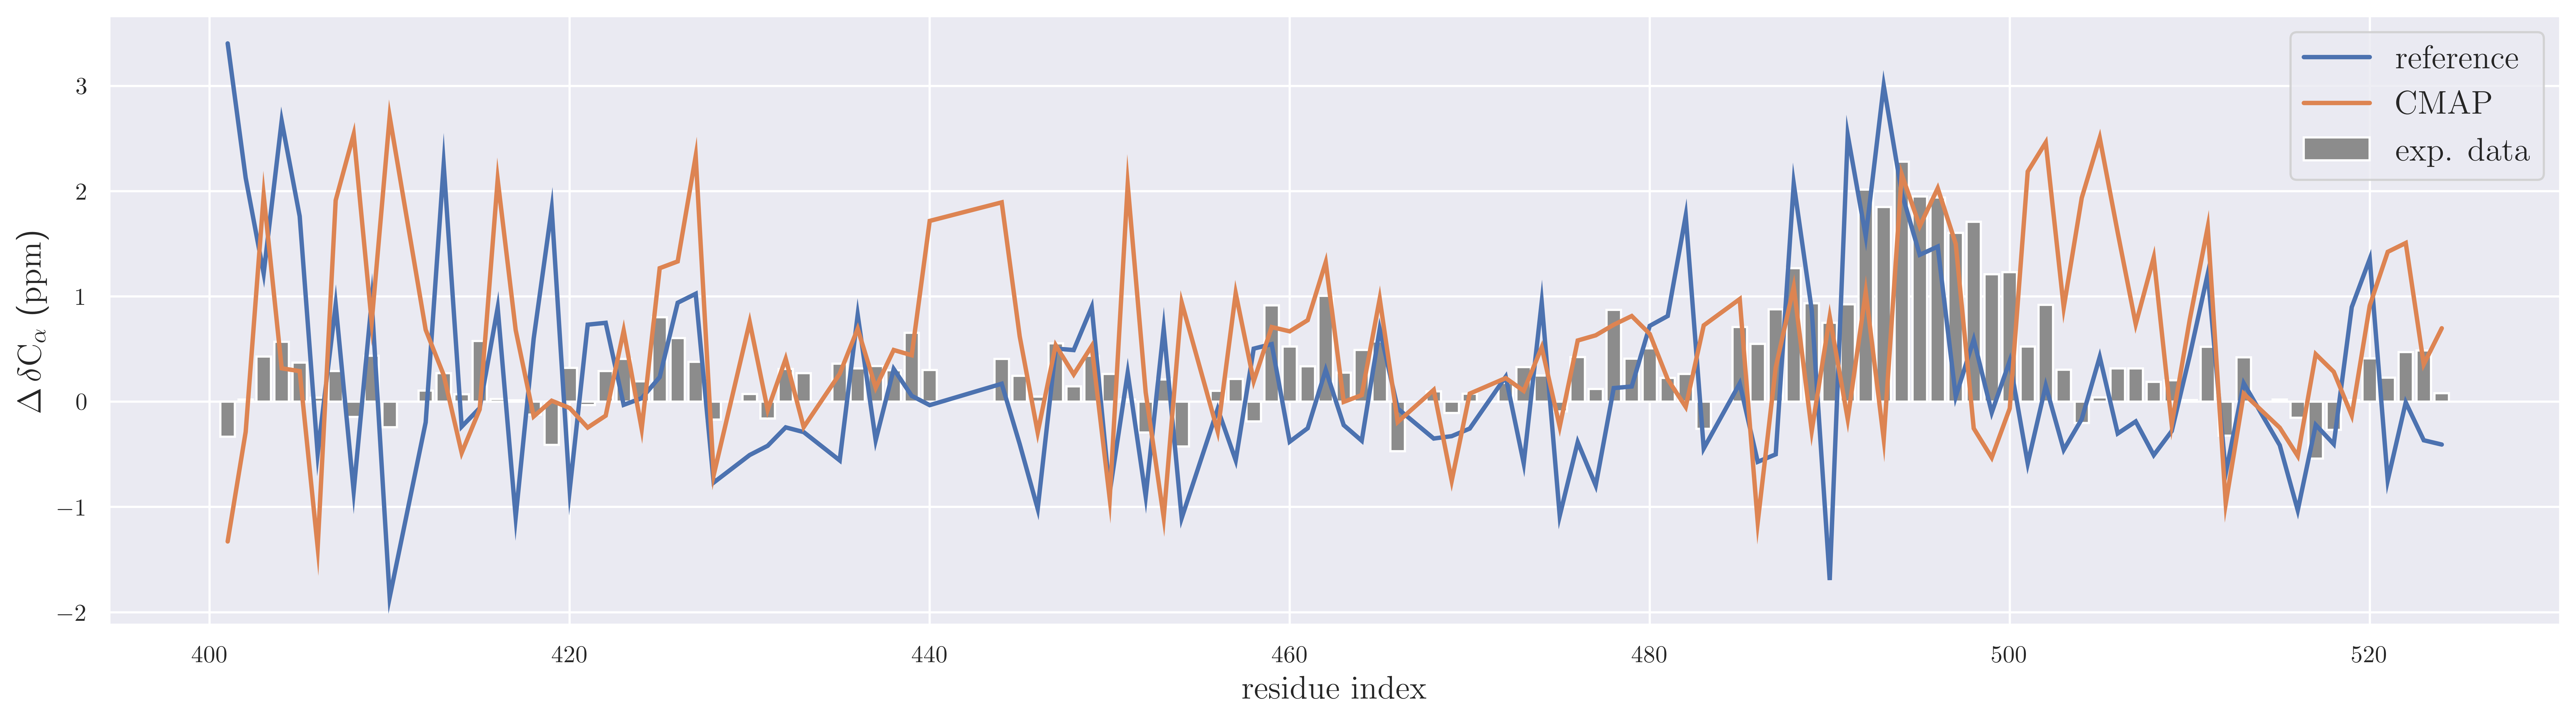

In [70]:
plot_cs(ref_cs_df.xs("CA", level="name"), cmap_cs_df.xs("CA", level="name"), hncoca_df["CA"], "CA")


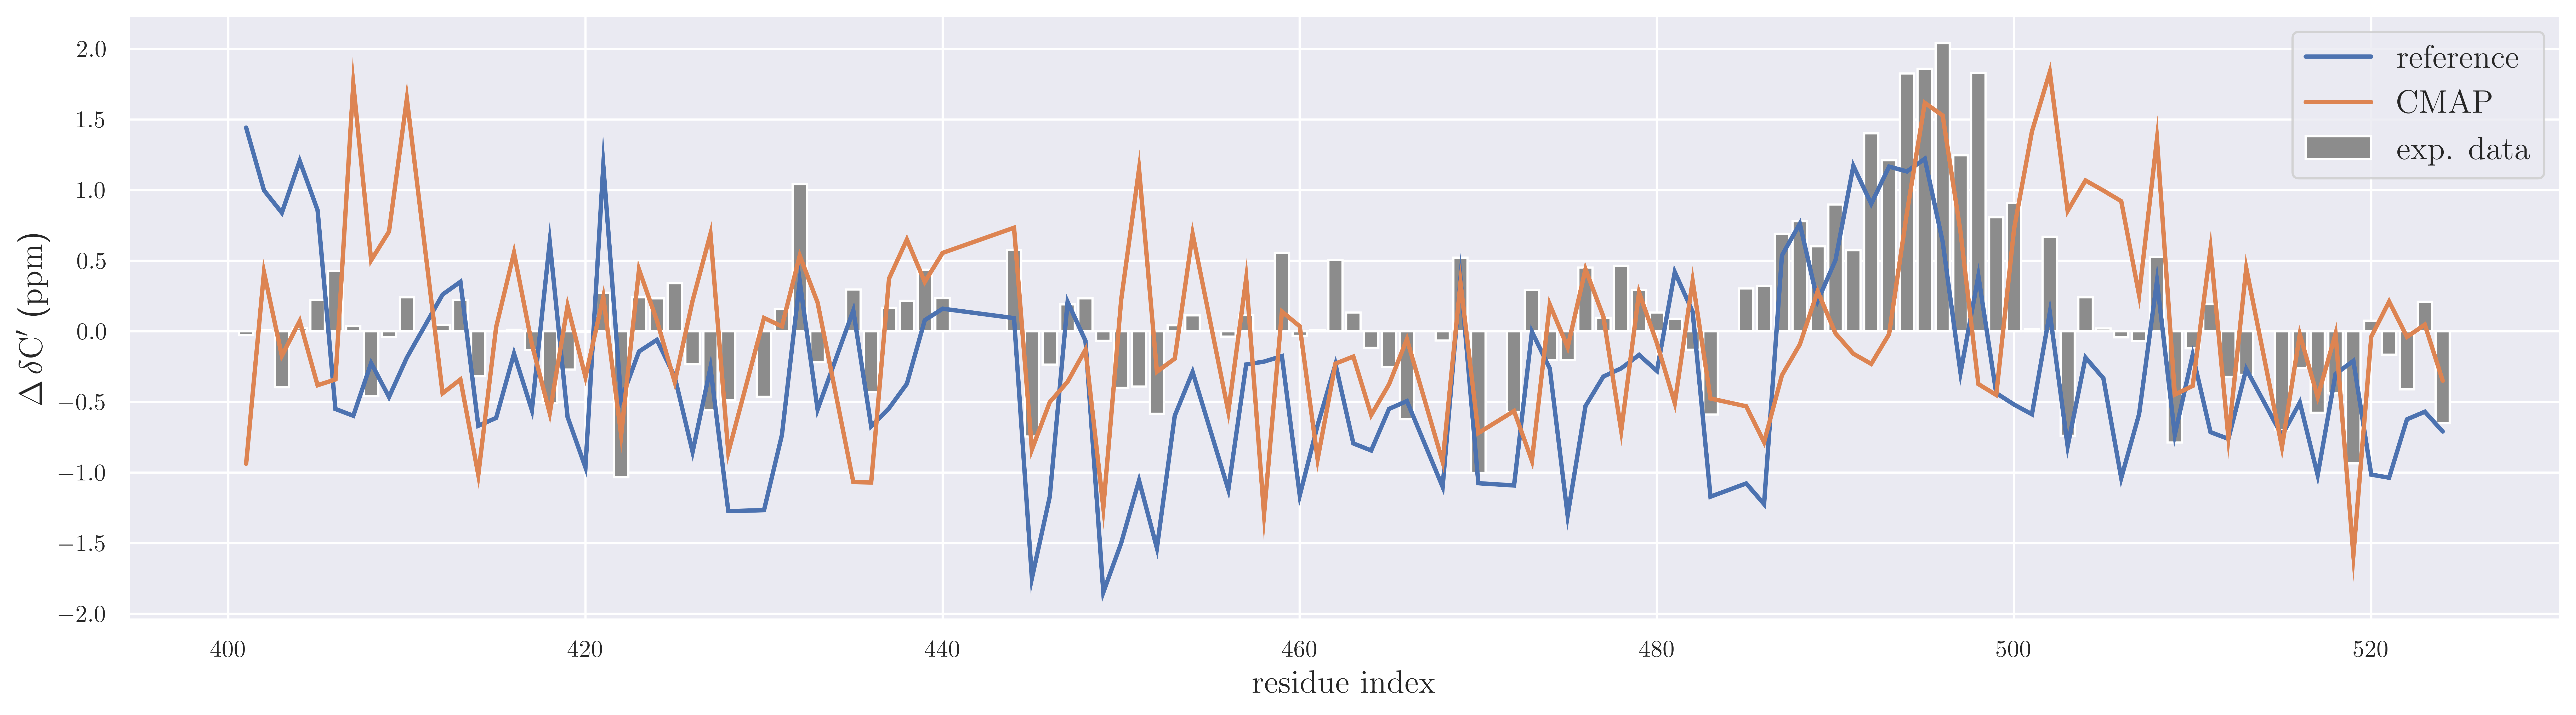

In [71]:
plot_cs(ref_cs_df.xs("C", level="name"), cmap_cs_df.xs("C", level="name"), hnco_df["C"], "C")


## Multiple trajectories CS averages

In [40]:
def compute_cs_df(basedir, period=100):
    basedir = Path(basedir)

    xtcs = list(basedir.glob("*a_132/md_nojump.xtc"))

    pdbs = [xtc.with_suffix(".pdb") for xtc in xtcs]

    dfs = []

    for pdb, xtc in zip(pdbs, xtcs):
        conformer = parse("{:d}a_132", pdb.parent.name)[0]
        print(conformer)
        traj = mdt.load(xtc, top=pdb)

        one_every = round(period / traj.timestep)
        inds = np.arange(0, traj.time.size, one_every)
        subtraj = traj[inds]
        df = compute_chem_shift(subtraj, atoms=["CA", "C", "N"])

        df["conformer"] = conformer

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.set_index("conformer", append=True)

    return df


ref_cs_df = compute_cs_df("/home/gzappavigna/traj/20241018_ff99sb-ildn_opc_multidir")
cmap_cs_df = compute_cs_df("/home/gzappavigna/traj/20241025_ff99sb-ildn_opc_cmap_multidir/")


3097
6811
4622
7057
13589
11199
14470
10440
14017
8104
15062
9802
13573
10717
1528
19517
9380
7982
9613
9510
12724
5970
7169
17425
11038
6591
4618
1120
14037
836
6125
13939
17396
11561
1313
10072
3125
5033
7576
1911
15070
3359
12973
14122
8523
3069
15809
6734
6235
5813
15996
11591
16074
11618
4070
1386
812
2504
9056
2292
12877
10498
5188
16179
724
7054
13162
16527
12088
13889
3075
8041
13609
10099
16258
14744
2938
8508
4492
11972
7719
4425
290
1220
10216
2923
10777
1340
927
12237
1532
5731
6921
873
15776
7753
3097
6811
4622
7057
13589
11199
14470
10440
14017
8104
15062
9802
13573
10717
1528
19517
9380
7982
9613
9510
12724
5970
7169
17425
11038
6591
4618
1120
14037
836
6125
13939
17396
11561
1313
10072
3125
5033
7576
1911
15070
3359
12973
14122
8523
3069
15809
6734
6235
5813
15996
11591
16074
11618
4070
1386
812
2504
9056
2292
12877
10498
5188
16179
724
7054
13162
16527
12088
13889
3075
8041
13609
10099
16258
14744
2938
8508
4492
11972
7719
4425
290
1220
10216
2923
10777
1340
927
12237


In [42]:
ref_cs_df["SIGMA2"] = ref_cs_df["SIGMA"] ** 2
ref_grouper = ref_cs_df.groupby(["frame", "resSeq", "name"])
ref_avg_cs_df = ref_grouper[["RC_SHIFT", "SHIFT", "SS_SHIFT"]].mean()
ref_avg_cs_df["SIGMA"] = np.sqrt(ref_grouper["SIGMA2"].sum()) / ref_grouper["SIGMA"].count()

cmap_cs_df["SIGMA2"] = cmap_cs_df["SIGMA"] ** 2
cmap_grouper = cmap_cs_df.groupby(["frame", "resSeq", "name"])
cmap_avg_cs_df = cmap_grouper[["RC_SHIFT", "SHIFT", "SS_SHIFT"]].mean()
cmap_avg_cs_df["SIGMA"] = np.sqrt(cmap_grouper["SIGMA2"].sum()) / cmap_grouper["SIGMA"].count()


In [43]:
ref_avg_cs_df.to_csv("ref_avg_cs_df.csv")
cmap_avg_cs_df.to_csv("cmap_avg_cs_df.csv")

In [42]:
ref_avg_cs_df = pd.read_csv("ref_avg_cs_df.csv", index_col=["frame", "resSeq", "name"])
cmap_avg_cs_df = pd.read_csv("cmap_avg_cs_df.csv", index_col=["frame", "resSeq", "name"])

In [43]:
idx = ref_avg_cs_df.index.names.index("resSeq")
ref_avg_cs_df.index = ref_avg_cs_df.index.set_levels(ref_avg_cs_df.index.levels[idx] + 401 - 8, level=idx)
idx = ref_avg_cs_df.index.names.index("frame")
ref_avg_cs_df.index = ref_avg_cs_df.index.set_levels(ref_avg_cs_df.index.levels[idx] / 10, level=idx)


idx = cmap_avg_cs_df.index.names.index("resSeq")
cmap_avg_cs_df.index = cmap_avg_cs_df.index.set_levels(cmap_avg_cs_df.index.levels[idx] + 401 - 8, level=idx)
idx = cmap_avg_cs_df.index.names.index("frame")
cmap_avg_cs_df.index = cmap_avg_cs_df.index.set_levels(cmap_avg_cs_df.index.levels[idx] / 10, level=idx)





In [44]:
palette = sns.color_palette()

def plot_first_last_cs(cs_df, exp_cs, atom, color):

    atom_to_tex = {
        "CA": r"\ce{C_{\alpha}}",
        "C": r"\ce{C^{\prime}}",
        "N": r"\ce{N}",
    }


    cs_df = cs_df.xs(atom, level="name")
    exp_cs = exp_cs[atom]


    ts = cs_df.index.get_level_values('frame')
    t_min, t_max = ts.min(), ts.max()

    rc_cs = cs_df["RC_SHIFT"].xs(t_min, level="frame")

    first_cs = cs_df["SHIFT"].xs(t_min, level="frame")
    last_cs = cs_df["SHIFT"].xs(t_max, level="frame")
    # print(first_cs)

    exp_scs = (exp_cs - rc_cs).dropna()

    first_scs = first_cs - rc_cs
    last_scs = last_cs - rc_cs

    first_scs = first_scs.loc[exp_scs.index]
    last_scs = last_scs.loc[exp_scs.index]


    plt.figure(figsize=(20, 5), dpi=600)

    plt.bar(exp_scs.index, exp_scs, color=palette[-3], label=r"\textrm{exp. data}")
    plt.plot(first_scs, ls="--", lw=1.5, color=color, solid_joinstyle="miter", label=rf"$t = \qty{{{t_min:.0f}}}{{\ns}}$")
    plt.plot(last_scs, lw=1.5, color=color, solid_joinstyle="miter", label=rf"$t = \qty{{{t_max:.0f}}}{{\ns}}$")
    plt.xlabel(r"\textrm{residue index}", fontsize=15)
    plt.ylabel(rf"$\Delta\, \delta {atom_to_tex[atom]}$ (\unit{{ppm}})", fontsize=15)
    plt.legend(fontsize=15)



In [50]:
hncoca_df

CA        N     HN
resid                        
401    61.768  116.006  8.227
402    62.120  122.950  8.437
403    56.830  121.548  8.326
404    54.571  121.138  8.209
405    56.659  121.142  8.048
...       ...      ...    ...
520    54.411  120.790  8.183
521    56.330  119.179  8.440
522    53.522  121.904  8.079
523    55.327  122.212  8.089
524    54.921  126.210  7.751

[113 rows x 3 columns]

In [51]:
exp_cs_df

CA        C     HN        N
resid                                 
402    62.120  174.710  8.437  116.006
403    56.830  176.204  8.326  122.950
404    54.571  176.322  8.209  121.548
405    56.659  176.822  8.048  121.138
406    61.339  176.544  8.344  121.142
...       ...      ...    ...      ...
520    54.411  176.376  8.183  120.847
521    56.330  176.135  8.440  120.790
522    53.522  175.098  8.079  119.179
523    55.327  177.080  8.089  121.904
524    54.921  176.219  7.751  122.212

[103 rows x 4 columns]

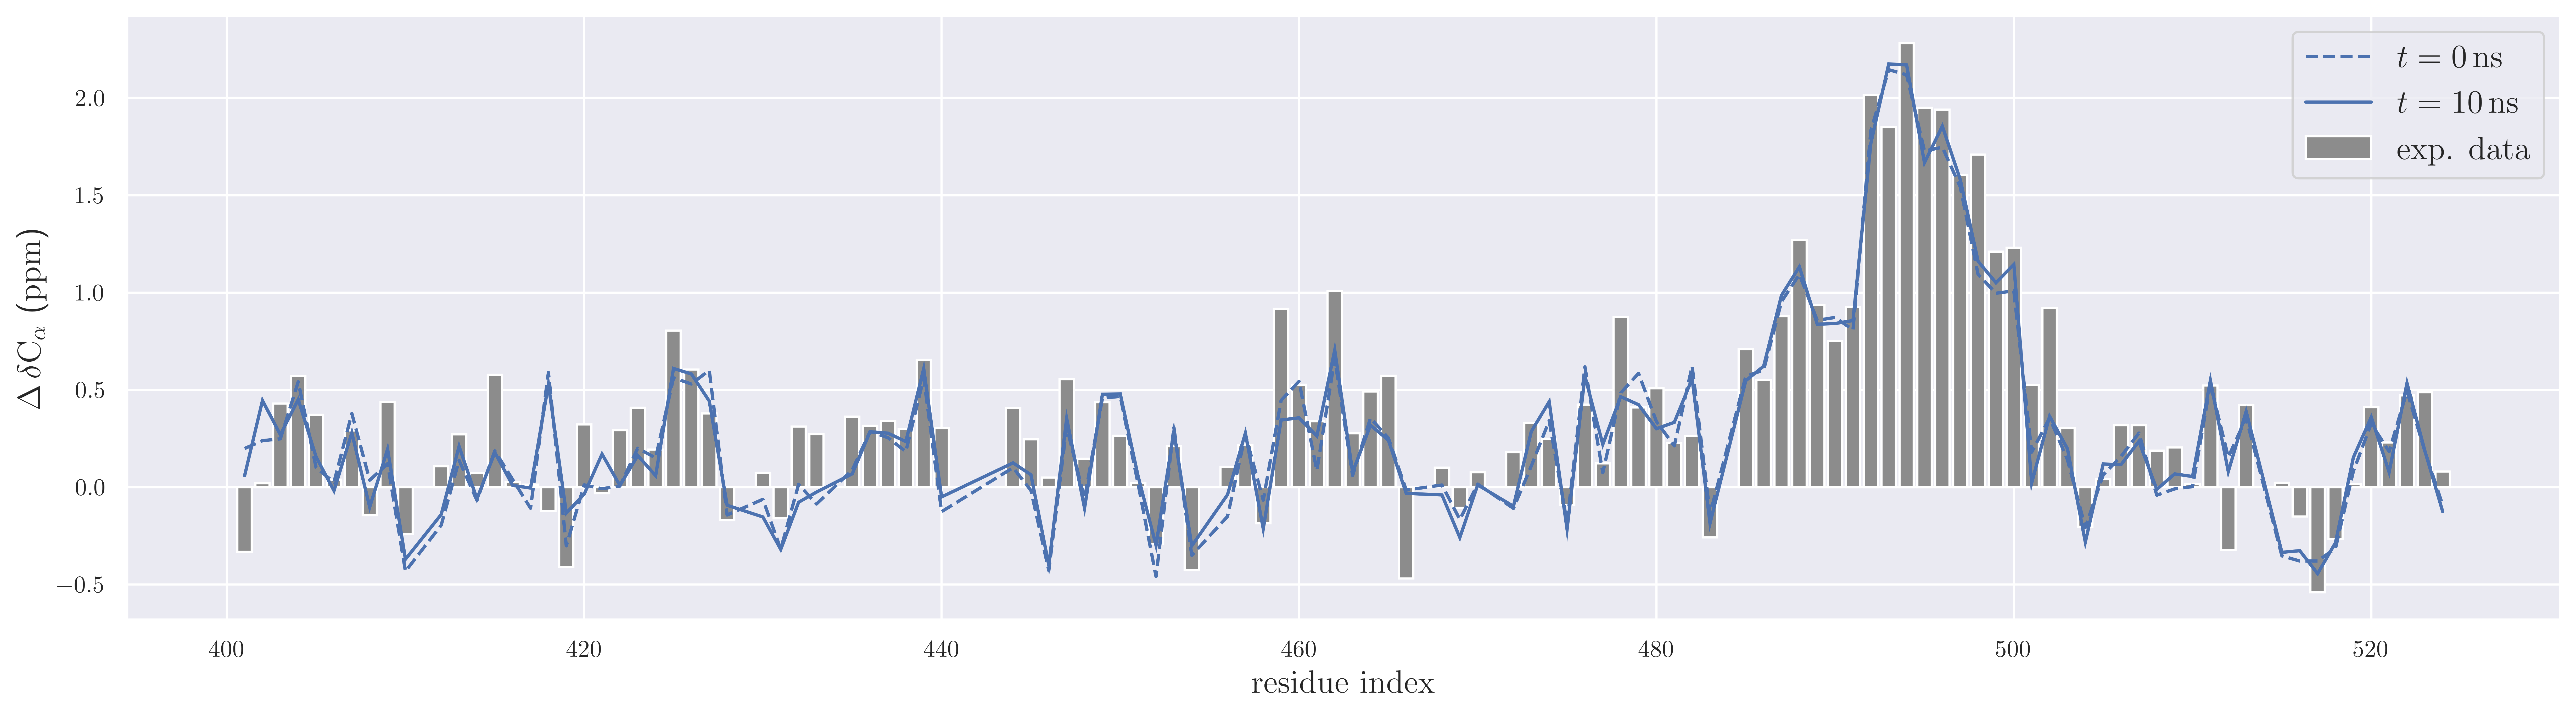

In [49]:
plot_first_last_cs(ref_avg_cs_df, hncoca_df, "CA", palette[0])


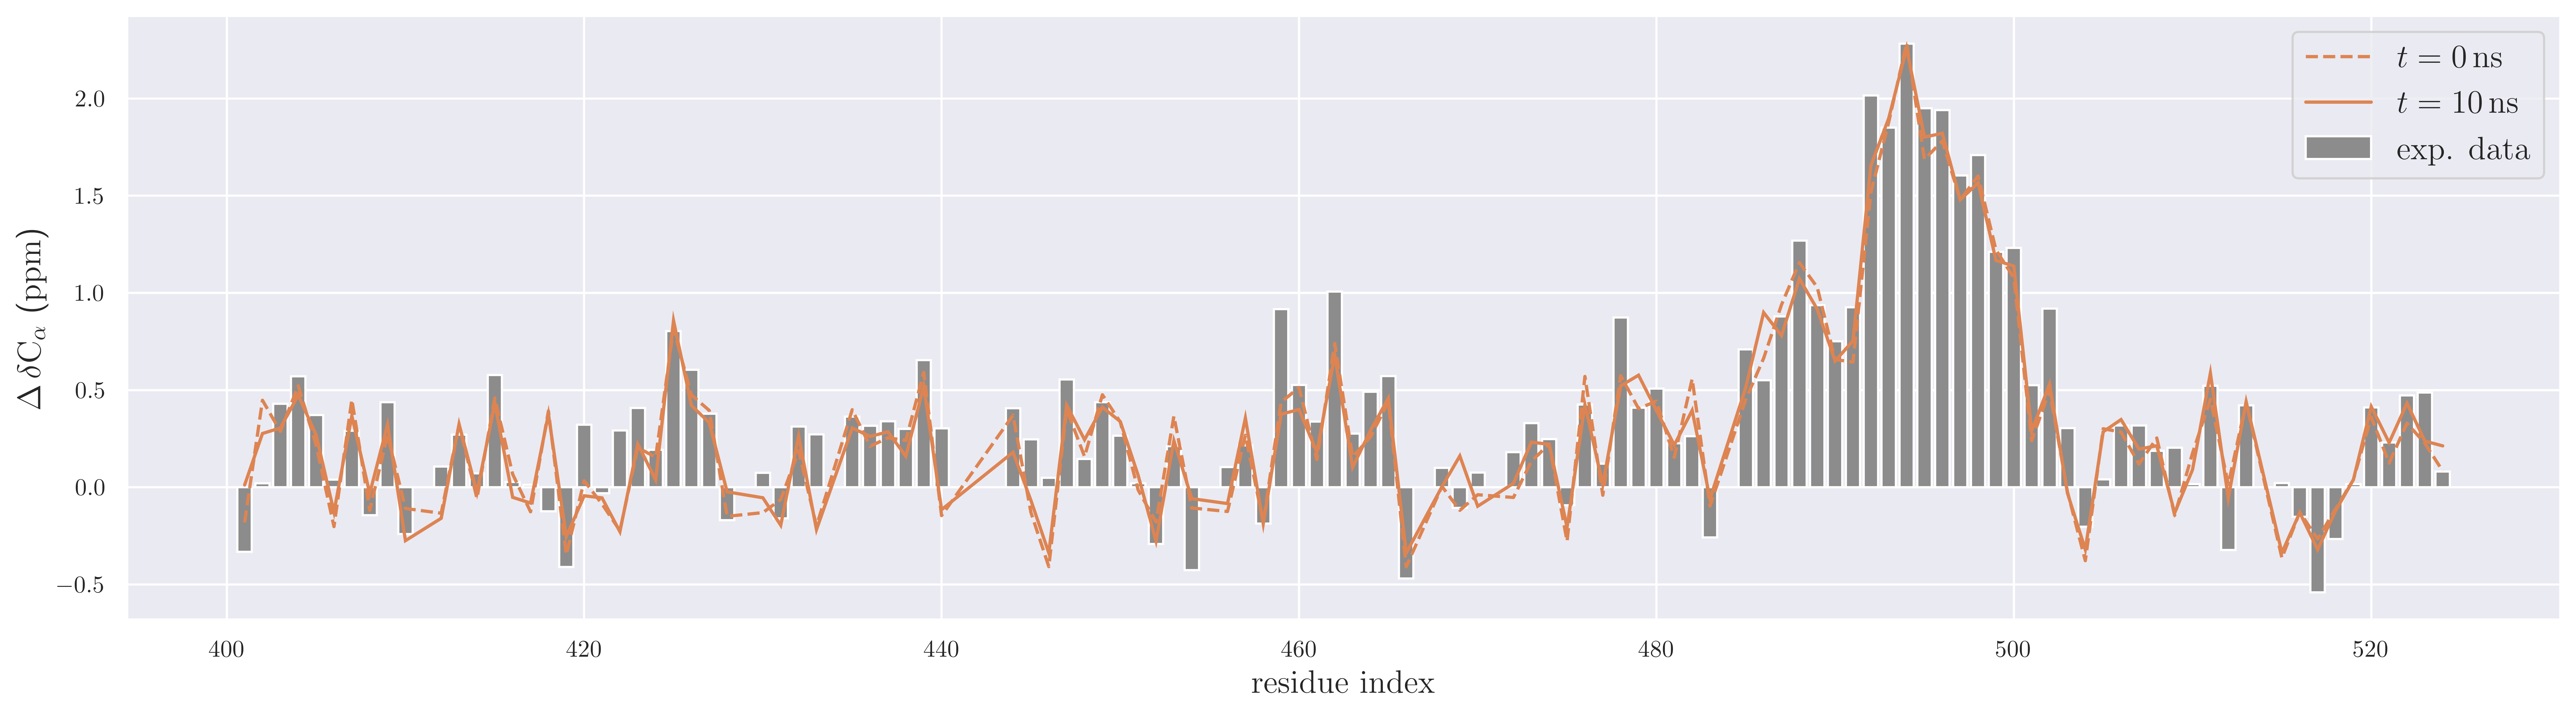

In [23]:
plot_first_last_cs(cmap_avg_cs_df, hncoca_df, "CA", palette[1])
# plot_first_last_cs(cmap_avg_cs_df, hnco_df, "C", palette[1])



In [ ]:
# plot_first_last_cs(cmap_avg_cs_df, hnco_df, "C", palette[1])


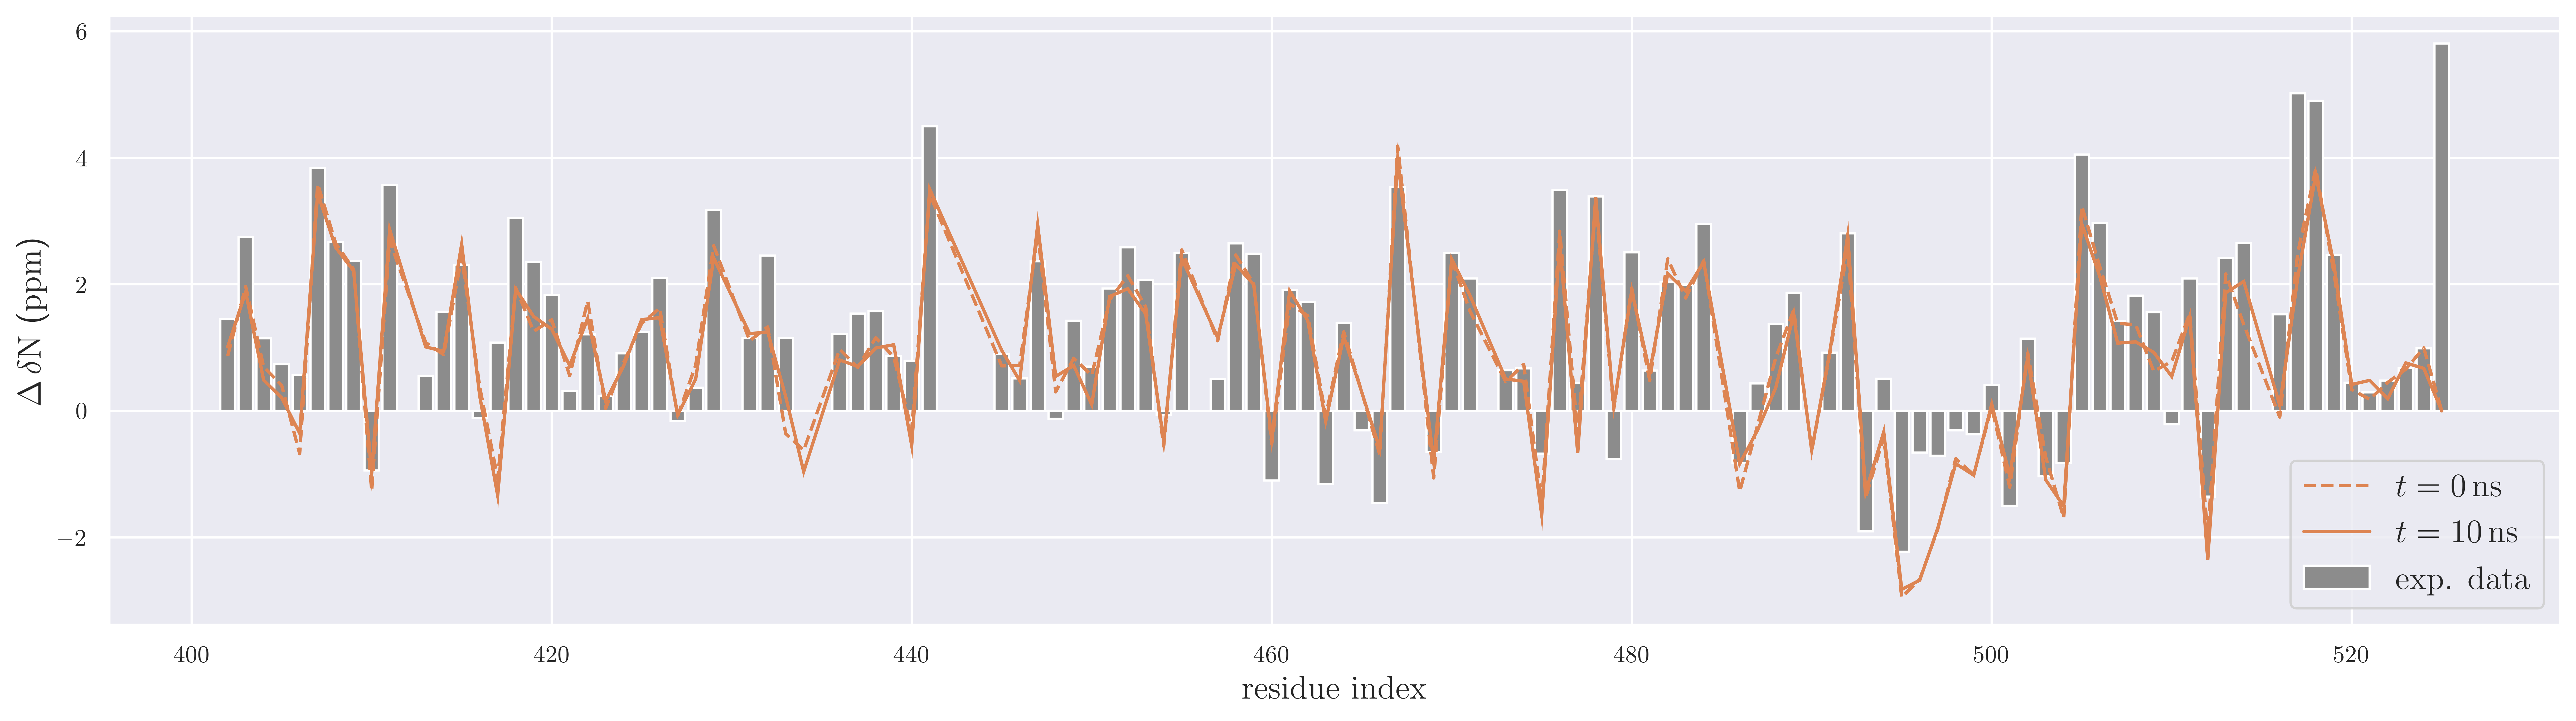

In [98]:
plot_first_last_cs(cmap_avg_cs_df, hncoca_df.set_index(hncoca_df.index + 1), "N", palette[1])


In [134]:
def cs_rmsd(cs_df, exp_cs):
    ts = cs_df.index.get_level_values("frame").unique().sort_values()

    rmsd_list = []
    sigma_list = []

    for t in ts:
        sel_cs_df = cs_df.xs(t, level="frame")

        cs = sel_cs_df["SHIFT"]
        cs_sigma2 = sel_cs_df["SIGMA"] ** 2

        sd = (cs - exp_cs) ** 2
        mask = sd.notna()

        sd = sd[mask]
        cs_sigma2 = cs_sigma2[mask]

        rmsd = np.sqrt(np.mean(sd))

        sigma = np.sqrt(np.sum(sd * cs_sigma2)) / (sd.count() * rmsd)

        rmsd_list.append(rmsd)
        sigma_list.append(sigma)

    return ts, np.array(rmsd_list), np.array(sigma_list)



def plot_cs_rmsd(ref_avg_cs_df, cmap_avg_cs_df, exp_cs, atom):
    atom_to_tex = {
        "CA": r"\ce{C_{\alpha}}",
        "C": r"\ce{C^{\prime}}",
        "N": r"\ce{N}",
    }

    ts_ref, ref_rmsd, ref_sigma = cs_rmsd(ref_avg_cs_df.xs(atom, level="name"), exp_cs[atom])
    ts_cmap, cmap_rmsd, cmap_sigma = cs_rmsd(cmap_avg_cs_df.xs(atom, level="name"), exp_cs[atom])

    plt.figure(dpi=300)
    plt.plot(ts_ref / 10, ref_rmsd, label=r"\textrm{reference}")
    plt.fill_between(ts_ref / 10, ref_rmsd - ref_sigma, ref_rmsd + ref_sigma, alpha=0.3)
    plt.plot(ts_cmap / 10, cmap_rmsd, label=r"\textrm{CMAP}")
    plt.fill_between(
        ts_cmap / 10, cmap_rmsd - cmap_sigma, cmap_rmsd + cmap_sigma, alpha=0.3
    )

    plt.xlabel(r"$t$ (\unit{\ns})")
    plt.ylabel(rf"$\delta {atom_to_tex[atom]}$ \textrm{{RMSD from exp. data}} (\unit{{ppm}})")
    plt.legend(loc="upper right")


In [135]:
# ts_ref, ref_rmsd, ref_sigma = cs_rmsd(ref_avg_cs_df.xs("CA", level="name"), hncoca_df["CA"])
# ts_cmap, cmap_rmsd, cmap_sigma = cs_rmsd(cmap_avg_cs_df.xs("CA", level="name"), hncoca_df["CA"])

# plt.figure(dpi=300)
# plt.plot(ts_ref / 10, ref_rmsd, label=r"\textrm{reference}")
# plt.fill_between(ts_ref / 10, ref_rmsd - ref_sigma, ref_rmsd + ref_sigma, alpha=0.3)
# plt.plot(ts_cmap / 10, cmap_rmsd, label=r"\textrm{CMAP}")
# plt.fill_between(
#     ts_cmap / 10, cmap_rmsd - cmap_sigma, cmap_rmsd + cmap_sigma, alpha=0.3
# )

# plt.xlabel(r"$t$ (\unit{\ns})")
# plt.ylabel(r"$\delta \ce{C_{\alpha}}$ \textrm{RMSD from exp. data} (\unit{ppm})")
# plt.legend()
# # plt.tight_layout()

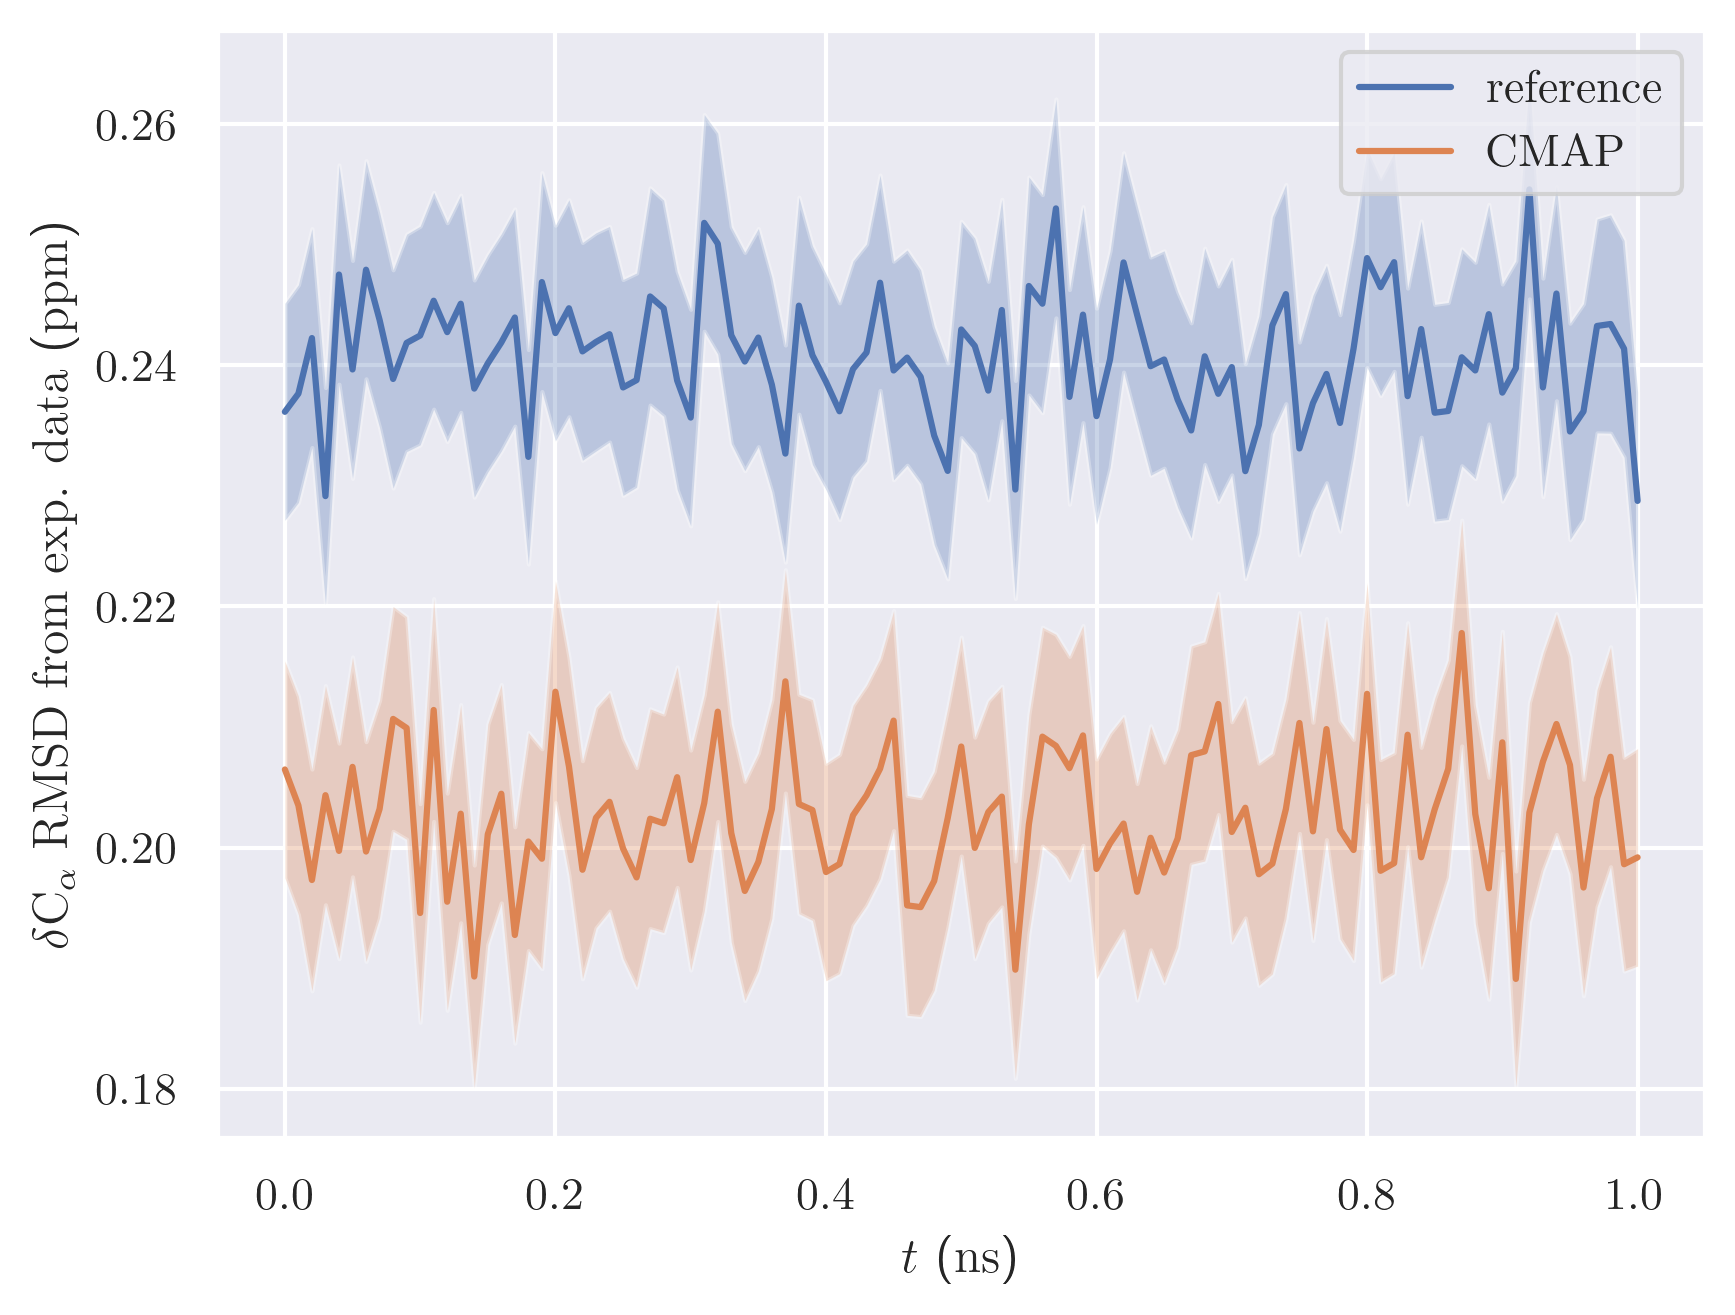

In [136]:
plot_cs_rmsd(ref_avg_cs_df, cmap_avg_cs_df, hncoca_df, "CA")

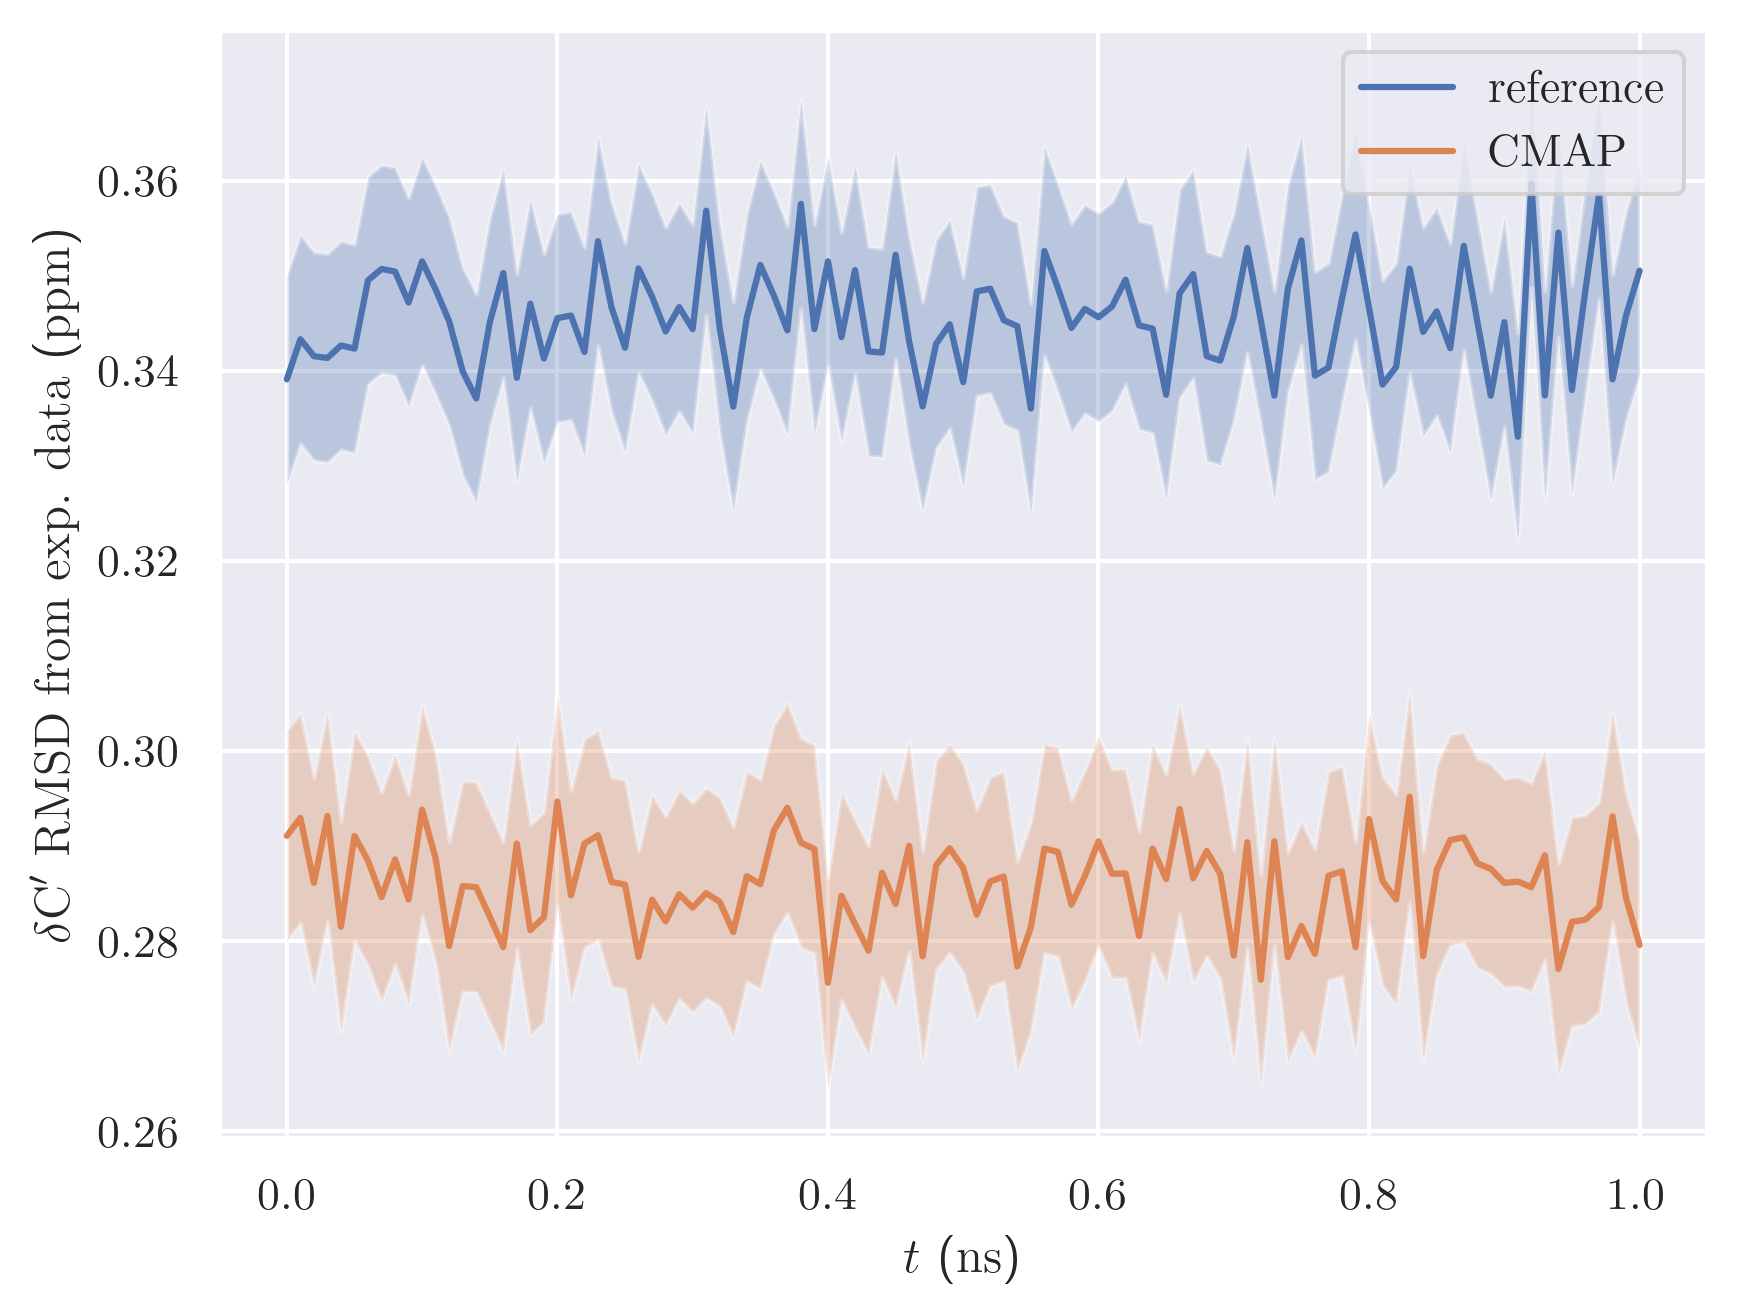

In [137]:
plot_cs_rmsd(ref_avg_cs_df, cmap_avg_cs_df, hnco_df, "C")

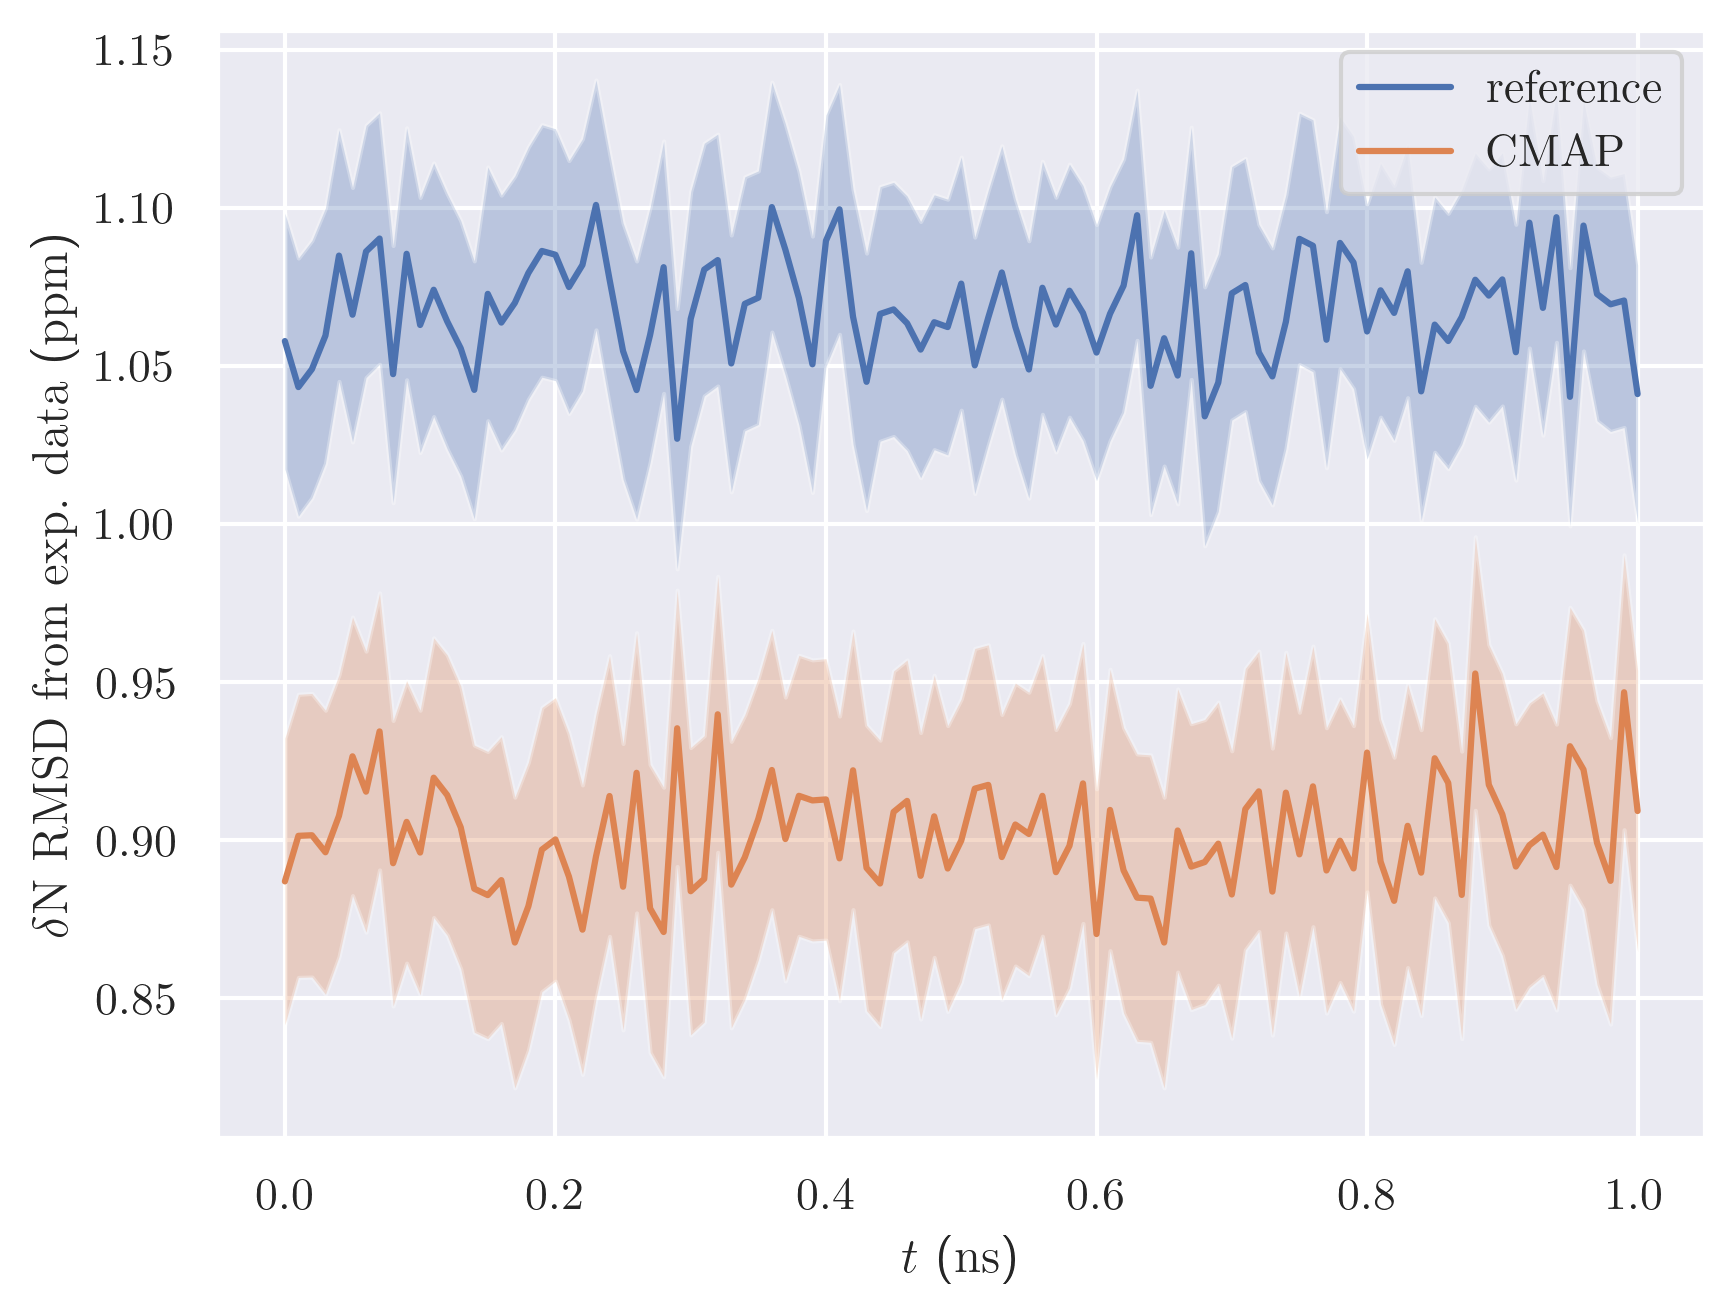

In [138]:
plot_cs_rmsd(ref_avg_cs_df, cmap_avg_cs_df, hnco_df.set_index(hnco_df.index + 1), "N")

In [33]:
# ts_ref, ref_rmsd, ref_sigma = cs_rmsd(ref_avg_cs_df.xs("C", level="name"), hnco_df["C"])
# ts_cmap, cmap_rmsd, cmap_sigma = cs_rmsd(cmap_avg_cs_df.xs("C", level="name"), hnco_df["C"])

# plt.figure(dpi=300)
# plt.plot(ts_ref / 10, ref_rmsd, label=r"\textrm{reference}")
# plt.fill_between(ts_ref / 10, ref_rmsd - ref_sigma, ref_rmsd + ref_sigma, alpha=0.3)
# plt.plot(ts_cmap / 10, cmap_rmsd, label=r"\textrm{CMAP}")
# plt.fill_between(
#     ts_cmap / 10, cmap_rmsd - cmap_sigma, cmap_rmsd + cmap_sigma, alpha=0.3
# )

# plt.xlabel(r"$t$ (\unit{\ns})")
# plt.ylabel(r"$\delta \ce{C^{\prime}}$ \textrm{RMSD from exp. data} (\unit{ppm})")
# plt.legend()
# # plt.legend(loc="upper left")
# plt.tight_layout()